# Improving Deep Neural Networks: Regularization¶


Welcome to the next hands-on session of this week. Deep Learning models have so much flexibility and capacity that overfitting can be a serious problem, if the training dataset is not big enough. Sure it does well on the training set, but the learned network doesn't generalize to new examples that it has never seen!  


So, let's get started.

## Packages

Let's first import all the packages that you will need during this assignment. 
- [numpy](https://www.numpy.org/) is the fundamental package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) is a library to plot graphs in Python.
- [h5py](http://www.h5py.org) is a common package to interact with a dataset that is stored on an H5 file.
- [PIL](http://www.pythonware.com/products/pil/) and [scipy](https://www.scipy.org/) are used here to test your model with your own picture at the end.
- dnn_app_utils provides the functions implemented in the "Building your Deep Neural Network: Step by Step" assignment to this notebook.
- np.random.seed(1) is used to keep all the random function calls consistent. It will help us grade your work.

In [3]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from dnn_app_utils_v3 import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Dataset

**Problem Statement**: You are given a dataset (".csv") containing:

Let's get more familiar with the dataset. Load the data by running the cell below.

In [4]:
# Loading the data 
def read_data(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
    
    num_points = len(lines)
    dim_points = 28 * 28
    data = np.empty((num_points, dim_points))
    labels = np.empty(num_points)
    
    for ind, line in enumerate(lines):
        num = line.split(',')
        labels[ind] = int(num[0])
        data[ind] = [ int(x) for x in num[1:] ]
        
    return (data, labels)

train_set_x_flatten, train_y = read_data("sample_train.csv")
test_set_x_flatten, test_y = read_data("sample_test.csv")
print(train_set_x_flatten.shape, test_set_x_flatten.shape)
print(train_y.shape, test_y.shape)

(6000, 784) (1000, 784)
(6000,) (1000,)


The following code will show you an image in the dataset. Feel free to change the index and re-run the cell multiple times to see other images. 

y = 2.0


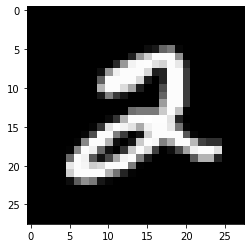

In [5]:
# Example of a picture
index = 5
img = train_set_x_flatten[index,:].reshape(28,28)
plt.imshow(img, cmap = 'gray')
print ("y = " + str(train_y[index]) )
#print(type(train_y[index]))

In [6]:
# Reshape the training and test examples 

train_set_x_flatten = train_set_x_flatten.T
#train_set_y = train_set_y.reshape(-1,1)
target = np.array(train_y).reshape(-1)
t = [int(x) for x in target]
print((t[5]))
train_set_y = np.eye(10)[t].T

print(train_set_y[:,5])

test_set_x_flatten = test_set_x_flatten.T
target = np.array(test_y).reshape(-1)
t = [int(x) for x in target]
print((t[2]))
test_set_y = np.eye(10)[t].T
print(test_set_y[:,2])

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

# Standardize data to have feature values between 0 and 1.
train_x = train_set_x_flatten/255.
test_x = test_set_x_flatten/255.


2
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
1
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
train_set_x_flatten shape: (784, 6000)
train_set_y shape: (10, 6000)
test_set_x_flatten shape: (784, 1000)
test_set_y shape: (10, 1000)


## L2 regularization

The standard way to avoid overfitting is called L2 regularization.

The general methodology to build a Neural Network is to:

1. Define the neural network structure ( # of input units,  # of hidden units, etc). 
2. Initialize the model's parameters
3. Loop:
    - Implement forward propagation
    - Compute loss
    - Implement backward propagation to get the gradients
    - Update parameters (gradient descent)


## Forward Propagation

Values needed in the backpropagation are stored in "cache". The cache will be given as an input to the backpropagation function.

In [7]:
def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Returns:
    params -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """
    
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

## Sigmoid Activation
def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """
    
    s = 1.0/(1.0 + np.exp(-1.0 * z))
    
    return s

# forward_propagation
def forward_propagation(X, parameters):
    """
    Argument:
    X -- input data of size (n_x, m)
    parameters -- python dictionary containing your parameters (output of initialization function)
            W1 -- weight matrix of shape (n_h, n_x)
            b1 -- bias vector of shape (n_h, 1)
            W2 -- weight matrix of shape (n_y, n_h)
            b2 -- bias vector of shape (n_y, 1)
    
    Returns:
    A2 -- The sigmoid output of the second activation
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2"
    """
    # Retrieve each parameter from the dictionary "parameters"
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Implement Forward Propagation to calculate A2 (probabilities)
    
    Z1 = np.add(np.matmul(W1, X), b1)
    A1 = np.tanh(Z1)
    Z2 = np.add(np.matmul(W2, A1), b2)
    A2 = sigmoid(Z2)
    
    assert(A2.shape == (W2.shape[0], X.shape[1]))
    
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache

## Cost Function with L2 Regularization

$$J = -\frac{1}{m} \sum\limits_{i = 1}^{m} \large{(}\small  y^{(i)}\log\left(a^{[L](i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right) \large{)}$$

$$J_{regularized} = \small \underbrace{-\frac{1}{m} \sum\limits_{i = 1}^{m} \large{(}\small y^{(i)}\log\left(a^{[L](i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right) \large{)} }_\text{cross-entropy cost} + \underbrace{\frac{1}{m} \frac{\lambda}{2} \sum\limits_l\sum\limits_k\sum\limits_j W_{k,j}^{[l]2} }_\text{L2 regularization cost} $$

In [8]:
# compute_cost
def compute_cost_with_regularization(A2, Y, parameters, lambd):
    """
    
    Arguments:
    A2 -- The sigmoid output of the second activation, of shape (n_y, number of examples)
    Y -- "true" labels vector of shape (n_y, number of examples)
    parameters -- python dictionary containing your parameters W1, b1, W2 and b2
    lambd -- regularization hyperparameter, scalar
    
    Returns:
    cost - value of the regularized loss function
    """
    
    m = Y.shape[1] # number of example
    W1 = parameters["W1"]
    W2 = parameters["W2"]

    # Compute the cross-entropy cost
    logprobs = np.multiply(Y, np.log(A2)) + np.multiply((1 - Y), np.log(1 - A2))
    cross_entropy_cost = (-1.0/(m*Y.shape[0])) * np.sum(logprobs)
    
    # Compute L2 regularization cost
    L2_regularization_cost = (np.sum(np.square(W1)) + np.sum(np.square(W2)))*(lambd/(2*m))
    
    # add cross_entropy_cost and L2_regularization_cost
    cost = cross_entropy_cost + L2_regularization_cost
    
    # makes sure cost is the dimension we expect. 
    cost = np.squeeze(cost)
    assert(isinstance(cost, float))
    
    return cost

## Backpropagation with L2 Regularization

In [9]:
# backward_propagation

def backward_propagation_with_regularization(X, Y, cache, parameters, lambd):
    """
    Implement the backward propagation using the instructions above.
    
    Arguments:
    parameters -- python dictionary containing our parameters 
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2".cache output from forward_propagation()
    X -- input data of shape (n_x, number of examples)
    Y -- "true" labels vector of shape (n_y, number of examples)
    lambd -- regularization hyperparameter, scalar
    
    Returns:
    grads -- python dictionary containing your gradients with respect to different parameters
    """
    m = X.shape[1]
    
    # First, retrieve W1 and W2 from the dictionary "parameters".
    W1 = parameters["W1"]
    W2 = parameters["W2"]
        
    # Retrieve also A1 and A2 from dictionary "cache".
    A1 = cache["A1"]
    A2 = cache["A2"]
    
    # Backward propagation: calculate dW1, db1, dW2, db2. Add the regularization term to dW2,dW1
    dZ2 = A2 - Y
    dW2 = (1.0/m) * np.matmul(dZ2, np.transpose(A1)) + (lambd/m)*W2 ## add the regularization term
    db2 = (1.0/m) * np.sum(dZ2, axis=1, keepdims=True)
    
    dZ1 = np.matmul(np.transpose(W2), dZ2) * (1 - np.power(A1, 2))
    dW1 = (1.0/m) * np.matmul(dZ1, np.transpose(X)) + (lambd/m)*W1 ## add the regularization
    db1 = (1.0/m) * np.sum(dZ1, axis=1, keepdims=True)
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads

## Implement the update rule.

Use gradient descent. We need (dW1, db1, dW2, db2) in order to update (W1, b1, W2, b2).



In [10]:
# update_parameters

def update_parameters(parameters, grads, learning_rate = 0.0075):
    """
    Updates parameters using the gradient descent update rule given above
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients 
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    """
    # Retrieve each parameter from the dictionary "parameters"
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Retrieve each gradient from the dictionary "grads"
    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]
    
    # Update rule for each parameter
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [11]:
### CONSTANTS DEFINING THE MODEL ####
n_x = 784     
n_h = 180
n_y = 10
layers_dims = (n_x, n_h, n_y)

In [12]:
# nn_model

def nn_model(X, Y, n_h, num_iterations = 10000, learning_rate=0.05, print_cost=True, lambd = 0.9):
    """
    Arguments:
    X -- dataset of shape (n_x, number of examples)
    Y -- labels of shape (n_y, number of examples)
    n_h -- size of the hidden layer
    num_iterations -- Number of iterations in gradient descent loop
    print_cost -- if True, print the cost every 1000 iterations
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    n_x = X.shape[0]
    n_y = Y.shape[0]
    
    # Initialize parameters, then retrieve W1, b1, W2, b2. Inputs: "n_x, n_h, n_y". Outputs = "W1, b1, W2, b2, parameters".
    parameters = initialize_parameters(n_x, n_h, n_y)
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Loop (gradient descent)
    costs = []
    for i in range(0, num_iterations):
         
        # Forward propagation. Inputs: "X, parameters". Outputs: "A2, cache".
        A2, cache = forward_propagation(X, parameters)
        
        # Cost function. Inputs: "A2, Y, parameters". Outputs: "cost".
        cost = compute_cost_with_regularization(A2, Y, parameters, lambd)
 
        # Backpropagation. Inputs: "parameters, cache, X, Y". Outputs: "grads".
        grads = backward_propagation_with_regularization(X, Y, cache, parameters, lambd)
 
        # Gradient descent parameter update. Inputs: "parameters, grads". Outputs: "parameters".
        parameters = update_parameters(parameters, grads, learning_rate=learning_rate)
        
        # cache all about model
        trained_model = {
            "layer_sizes": (n_x, n_h, n_y),
            "learning_rate": learning_rate,
            "costs": costs,
            "parameters": parameters
        }

        # Print the cost every 1000 iterations
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
       
    # plot the cost

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

    return trained_model

Cost after iteration 0: 0.693457
Cost after iteration 100: 0.270725
Cost after iteration 200: 0.169247
Cost after iteration 300: 0.127136
Cost after iteration 400: 0.106058
Cost after iteration 500: 0.093280
Cost after iteration 600: 0.084798
Cost after iteration 700: 0.078919
Cost after iteration 800: 0.074620
Cost after iteration 900: 0.071303


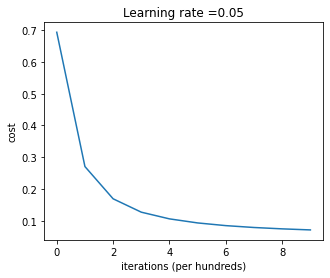

In [18]:
trained_model = nn_model(train_x, train_set_y, n_h, num_iterations = 1000, print_cost=True)

In [19]:
def predict(X, y, parameters):
    """
    This function is used to predict the results of a  L-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((y.shape[0],m))
    
    # Forward propagation    
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    Z1 = np.add(np.matmul(W1, X), b1)
    A1 = np.tanh(Z1)
    Z2 = np.add(np.matmul(W2, A1), b2)
    A2 = sigmoid(Z2)
    
    for i in range(0, A2.shape[1]):
        temp = np.array(A2[:,i])
        t = np.where(temp == np.amax(temp))
        p[t[0],i] = 1

    print("Accuracy: "  + str(np.sum(p == y)/(m* y.shape[0])))
        
    return p

In [20]:
predictions_train = predict(train_x, train_set_y, trained_model['parameters'])

Accuracy: 0.9841


In [21]:
predictions_test = predict(test_x, test_set_y, trained_model['parameters'])

Accuracy: 0.9776


# Visualization of MLP weights on MNIST

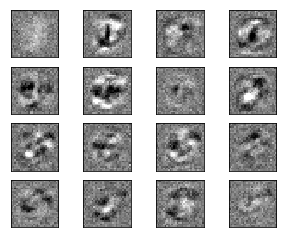

In [22]:
#print((np.array(list(trained_model['parameters']['W1'])).T).shape)

fig, axes = plt.subplots(4, 4)
# use global min / max to ensure all weights are shown on the same scale
vmin, vmax = (np.array(list(trained_model['parameters']['W1'])).T).min(), (np.array(list(trained_model['parameters']['W1'])).T).max()
for coef, ax in zip((np.array(list(trained_model['parameters']['W1']))), axes.ravel()):
    ax.matshow(coef.reshape(28, 28), cmap=plt.cm.gray, vmin=.5 * vmin,
               vmax=.5 * vmax)
    ax.set_xticks(())
    ax.set_yticks(())

plt.show()

## Check this out !

https://colab.research.google.com/drive/1fm5dXC5C4C85q4hCyq9ite2mERujWezM#scrollTo=cJcgZ-svxfrH